# Imports

In [313]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  Exception('Error Initialising Iminuit')

In [314]:
import os
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# Funcs

In [315]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [316]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [317]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [318]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Data

In [319]:
data = 'https://docs.google.com/spreadsheets/d/10J8iO8non_Iq_K_8JXAtarPfYMNR1pZCf4Qn8pPsk_4/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['RC', 'RL', 'RLC_sovra', 'RLC_sotto', 'RLC_crit'])


# other funcs

In [320]:
def find_file(path:str,name:str):
    for fname in os.listdir(path):    # change directory as needed
        if name in fname:
            return fname
    return None

In [321]:
def get_data(path:str):
    '''This function loads the data from the oscilloscope'''

    try:
        name = find_file(path,'CH1')
        if name != None:
            first_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float128) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float128)
        else:
            first_channel = None
    except:
        first_channel = None
        print('Error loading first channel')

    try:
        name = find_file(path,'CH2')
        if name != None:
            second_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float128) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float128)
        else:
            second_channel = None
    except:
        second_channel = None
        print('Error loading second channel')
        
    try:
        name = find_file(path,'MTH')
        if name != None:
            third_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float128) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float128)
        else:
            third_channel = first_channel[0], np.zeros(first_channel[0].shape)
    except:
        third_channel = first_channel[0], np.zeros(first_channel[0].shape)
        print('Error loading third channel')
    

    return first_channel, second_channel, third_channel

In [322]:
def V_RC(t,V_o,R,C,T, offset):
    return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))
    return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

def V_RC_2(t,V_o,R,C,T, offset):
    return -V_o*( 1 - 2*(np.exp(- ((t+offset)-(T/2)) /(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

def exp1(t,V_o,R,C,offset):
    return V_o*np.exp(-t/(R*C)) + offset

# RC

In [384]:
C_val = 49e-9

## R = 200 $\Omega$

In [379]:
RC_200_s_quadra, RC_200_s_data, RC_200_s_math  = get_data('data/RC_200_salita/')
RC_200_s_math = RC_200_s_data[0], (RC_200_s_quadra[1] - RC_200_s_data[1])

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0],RC_200_s_quadra[1],c='darkslateblue')
plt.plot(RC_200_s_data[0],RC_200_s_data[1], c='firebrick')
plt.plot(RC_200_s_math[0],RC_200_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza'])
plt.close()

777


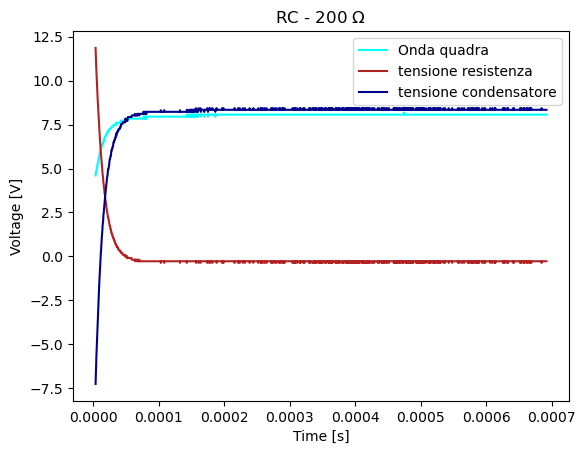

In [381]:
i = 0
v = RC_200_s_data[1][0]
while(v < np.max(RC_200_s_data[1])):
    v = RC_200_s_data[1][i]
    i+=1
print(i)

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0][i:],RC_200_s_quadra[1][i:], c='cyan')
plt.plot(RC_200_s_data[0][i:],  RC_200_s_data[1][i:],   c='firebrick')
plt.plot(RC_200_s_math[0][i:],  RC_200_s_math[1][i:],   c='darkblue')
# plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [382]:
c = LeastSquares(RC_200_s_math[0][777:],RC_200_s_math[1][777:], .01, exp1)
m = Minuit(c, R=250,V_o=8, C=49*1e-9, offset=0)
m.migrad()
m.hesse()
# m.minos()
plt.close()

In [390]:
c = LeastSquares(RC_200_s_math[0][777:],RC_200_s_math[1][777:], .063, V_RC)
m = Minuit(c, R=200, V_o=8.3314, C=C_val,T=0.025, offset=0)
m.fixed['T','C'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9304 (χ²/ndof = 5.4)       │              Nfcn = 93               │
│ EDM = 1.14e+04 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  8.3517   │  0.0016   │            │            │         │         │       │
│ 1 │ R      │   310.0   │    0.8    │            │            │    0    │         │       │
│ 2 │ C      │  49.0e-9  │  0.5e-9   │            │            │    0    │         │  yes  │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │    -0     │ 0.035e-6  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────┐
│        │           V_o             R             C             T        offset │
├────────┼───────────────────────────────────────────────────────────────────────┤
│    V_o │      2.55e-06      298.2e-6             0             0   10.2226e-12 │
│      R │      298.2e-6         0.649           0.0           0.0 24.9666433e-9 │
│      C │             0           0.0             0             0             0 │
│      T │             0           0.0             0             0             0 │
│ offset │   10.2226e-12 24.9666433e-9             0             0      1.23e-15 │
└────────┴───────────────────────────────────────────────────────────────────────┘

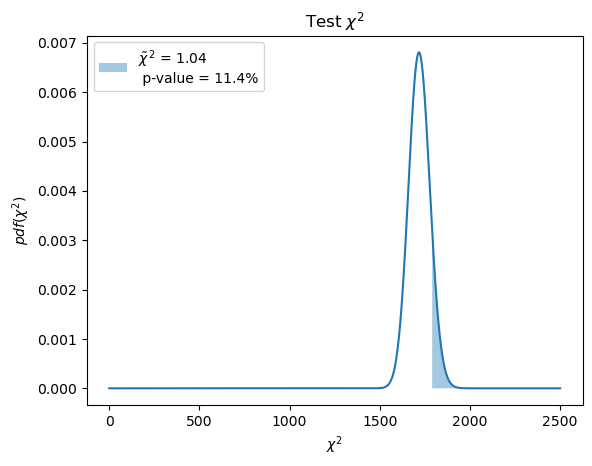

In [388]:
chi_test(m.fval, m.ndof, 2500)

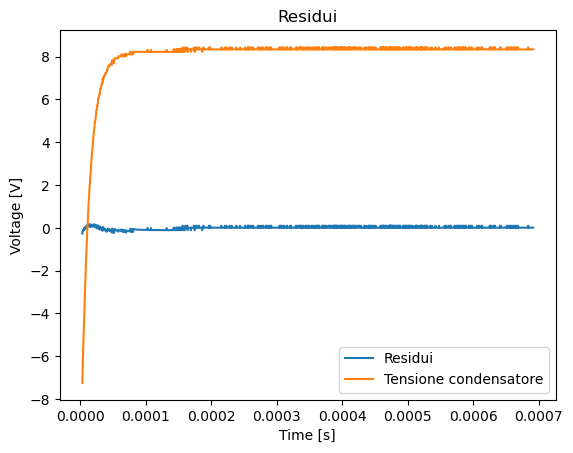

In [389]:
resti = [i-j for i,j in zip(RC_200_s_math[1][i:],V_RC(RC_200_s_math[0][i:],m.values['V_o'],m.values['R'],m.values['C'],m.values['T'],m.values['offset']))]
plt.title('Residui')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RC_200_s_math[0][i:],resti)
plt.plot(RC_200_s_math[0][i:],RC_200_s_math[1][i:])
plt.legend(['Residui','Tensione condensatore'])

In [393]:
Latex(f'$R_g$ = {m.values["R"]-200} $\Omega$')

<IPython.core.display.Latex object>

## R = 400 $\Omega$

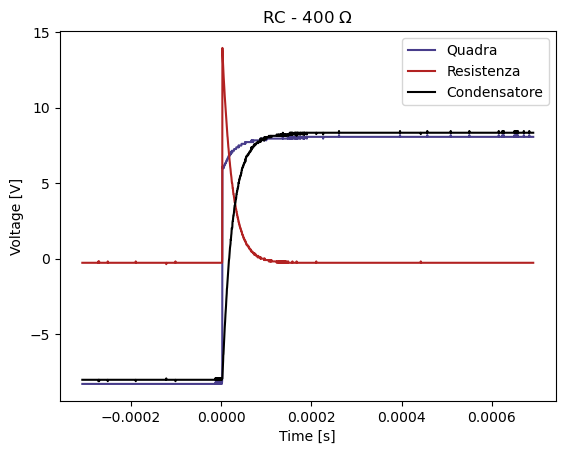

In [329]:
RC_400_s_quadra, RC_400_s_data, RC_400_s_math  = get_data('data/RC_400_salita/')
RC_400_s_math = RC_400_s_data[0], (RC_400_s_quadra[1] - RC_400_s_data[1])

plt.title('RC - 400 $\Omega$')
plt.plot(RC_400_s_quadra[0],RC_400_s_quadra[1],c='darkslateblue')
plt.plot(RC_400_s_data[0],RC_400_s_data[1], c='firebrick')
plt.plot(RC_400_s_math[0],RC_400_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza','Condensatore'])
plt.show()

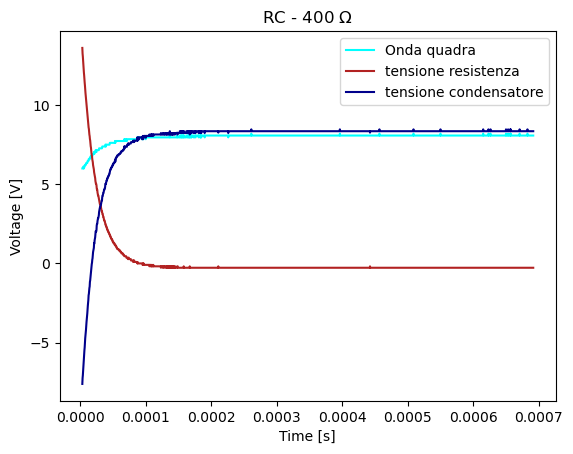

In [330]:
i = 0
v = RC_400_s_data[1][0]
while(v < np.max(RC_400_s_data[1])):
    v = RC_400_s_data[1][i]
    i+=1

plt.title('RC - 400 $\Omega$')
plt.plot(RC_400_s_quadra[0][i:],RC_400_s_quadra[1][i:],c='cyan')
plt.plot(RC_400_s_data[0][i:],RC_400_s_data[1][i:], c='firebrick')
plt.plot(RC_400_s_math[0][i:],RC_400_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [331]:
c = LeastSquares(RC_400_s_math[0][i:],RC_400_s_math[1][i:], .1, V_RC)
m = Minuit(c, R=471.1	,V_o=8.3242, C=49e-9,T=0.025, offset=0)
m.fixed['T','C'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 376.6 (χ²/ndof = 0.2)      │              Nfcn = 117              │
│ EDM = 1.93e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  8.3242   │  0.0026   │            │            │         │         │       │
│ 1 │ R      │   471.1   │    1.2    │            │            │    0    │         │       │
│ 2 │ C      │  49.0e-9  │  0.5e-9   │            │            │    0    │         │  yes  │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │ -1.98e-6  │  0.04e-6  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────┐
│        │           V_o             R             C             T        offset │
├────────┼───────────────────────────────────────────────────────────────────────┤
│    V_o │      6.72e-06        820e-6          0e-6          0e-6   21.0305e-12 │
│      R │        820e-6          1.35           0.0           0.0 35.9185833e-9 │
│      C │          0e-6           0.0             0             0             0 │
│      T │          0e-6           0.0             0             0             0 │
│ offset │   21.0305e-12 35.9185833e-9             0             0      1.68e-15 │
└────────┴───────────────────────────────────────────────────────────────────────┘

In [332]:
R_g = m.values['R'] - 399.1
R_g

72.00746787122546

## R = 700 $\Omega$

367


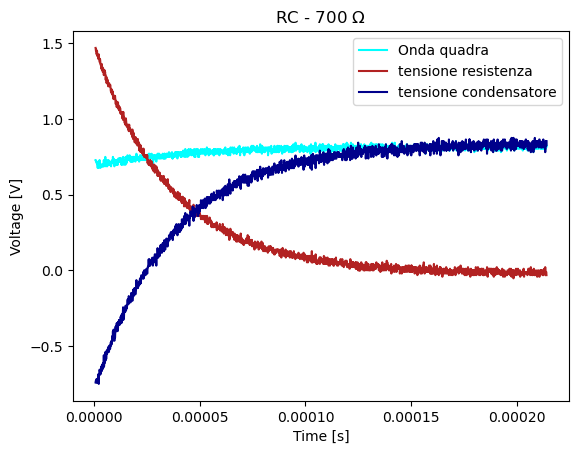

In [408]:
RC_700_s_quadra, RC_700_s_data, RC_700_s_math  = get_data('data/RC_700/')
RC_700_s_math = RC_700_s_data[0], (RC_700_s_quadra[1] - RC_700_s_data[1])

i = 0
v = RC_700_s_data[1][0]
while(v < np.max(RC_700_s_data[1])):
    v = RC_700_s_data[1][i]
    i+=1
print(i)

plt.title('RC - 700 $\Omega$')
plt.plot(RC_700_s_quadra[0][i:],RC_700_s_quadra[1][i:],c='cyan')
plt.plot(RC_700_s_data[0][i:],RC_700_s_data[1][i:], c='firebrick')
plt.plot(RC_700_s_math[0][i:],RC_700_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [404]:
c = LeastSquares(RC_700_s_math[0][208:],RC_700_s_math[1][208:], .1, V_RC)
m = Minuit(c, R=471.1	,V_o=8.3242, C=49e-9,T=0.025, offset=0)
m.fixed['T','C'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_3949/242545784.py:2: RuntimeWarning: overflow encountered in exp
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))
/tmp/ipykernel_3949/242545784.py:2: RuntimeWarning: invalid value encountered in divide
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8417 (χ²/ndof = 3.7)       │              Nfcn = 346              │
│ EDM = 425 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │   1.84    │   0.06    │            │            │         │         │       │
│ 1 │ R      │  4.60e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ C      │  49.0e-9  │  0.5e-9   │            │            │    0    │         │  yes  │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │ 145.4e-6  │  2.4e-6   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────┐
│        │            V_o              R              C              T         offset │
├────────┼────────────────────────────────────────────────────────────────────────────┤
│    V_o │         0.0032         2.8412         0.0000         0.0000    -136.742e-9 │
│      R │         2.8412       2.54e+03              0              0 -121.168642e-6 │
│      C │         0.0000              0              0              0          0e-12 │
│      T │         0.0000              0              0              0          0e-12 │
│ offset │    -136.742e-9 -121.168642e-6          0e-12          0e-12        5.9e-12 │
└────────┴────────────────────────────────────────────────────────────────────────────┘

## RC3 
<p1> R = 2k $\Omega$

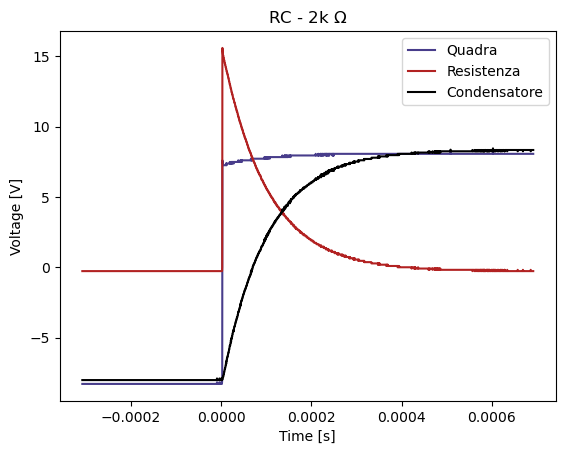

In [394]:
RC_2k_s_quadra, RC_2k_s_data, RC_2k_s_math  = get_data('data/RC_2k_salita/')
RC_2k_s_math = RC_2k_s_data[0], (RC_2k_s_quadra[1] - RC_2k_s_data[1])

plt.title('RC - 2k $\Omega$')
plt.plot(RC_2k_s_quadra[0],RC_2k_s_quadra[1],c='darkslateblue')
plt.plot(RC_2k_s_data[0],RC_2k_s_data[1], c='firebrick')
plt.plot(RC_2k_s_math[0],RC_2k_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza','Condensatore'])
plt.show()

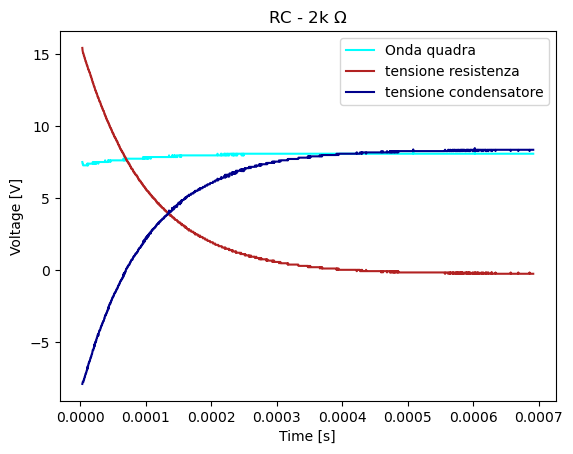

In [395]:
i = 0
v = RC_2k_s_data[1][0]
while(v < np.max(RC_2k_s_data[1])):
    v = RC_2k_s_data[1][i]
    i+=1

plt.title('RC - 2k $\Omega$')
plt.plot(RC_2k_s_quadra[0][i:],RC_2k_s_quadra[1][i:],c='cyan')
plt.plot(RC_2k_s_data[0][i:],RC_2k_s_data[1][i:], c='firebrick')
plt.plot(RC_2k_s_math[0][i:],RC_2k_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [335]:
c = LeastSquares(RC_2k_s_math[0][i:],RC_2k_s_math[1][i:], .01, V_RC)
m = Minuit(c, R=2000,V_o=8.35174, C=58.2e-9,T=0.025, offset=0)
m.fixed['T','R'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.584e+04 (χ²/ndof = 15.0) │              Nfcn = 177              │
│ EDM = 2.68e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  8.3472   │  0.0004   │            │            │         │         │       │
│ 1 │ R      │  2.072e3  │  0.021e3  │            │            │    0    │         │  yes  │
│ 2 │ C      │ 48.193e-9 │ 0.007e-9  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │ -1.325e-6 │ 0.009e-6  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────┐
│        │            V_o              R              C              T         offset │
├────────┼────────────────────────────────────────────────────────────────────────────┤
│    V_o │       1.35e-07              0 1.56478994e-15              0    1.64978e-12 │
│      R │              0              0              0              0              0 │
│      C │ 1.56478994e-15              0       4.57e-23              0      48.65e-21 │
│      T │              0              0              0              0              0 │
│ offset │    1.64978e-12              0      48.65e-21              0       8.14e-17 │
└────────┴────────────────────────────────────────────────────────────────────────────┘

# Funcs

In [336]:
def V_RL(t,V_o,R,L,T, offset):
    return V_o* 2*(np.exp(-t*R/L) / (1 + np.exp( -T*R/L) ) ) + offset

def V_RL_2(t,V_o,R,L,T):
    return V_o* 2*(np.exp(-(t-(T/2))*R/L) / (1 + np.exp( -T*R/L) ) )

In [337]:
def V_RL_basic(t,V_o,tau,c):
    return V_o*(np.exp(-t/tau))+c

# RL

## R = 100 $\Omega$

In [372]:
R_L = 39.4

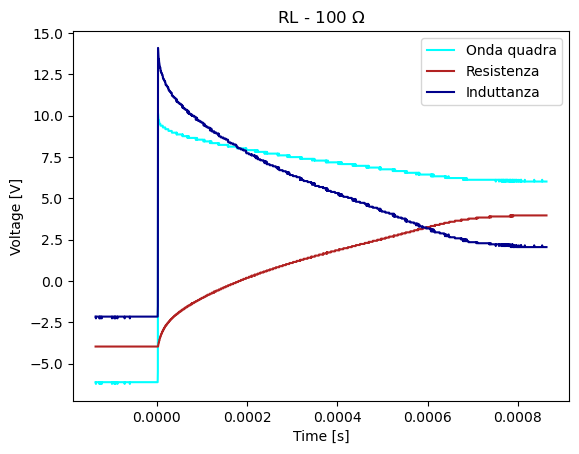

In [338]:
RL_100_s_quadra, RL_100_s_res, RL_100_s_ind  = get_data('data/RL_100_salita/')

RL_100_s_ind = RL_100_s_res[0], (RL_100_s_quadra[1] - RL_100_s_res[1])
plt.title('RL - 100 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')

plt.plot(RL_100_s_quadra[0],    RL_100_s_quadra[1],                     c='cyan')
plt.plot(RL_100_s_res[0],       RL_100_s_res[1],                        c='firebrick')
plt.plot(RL_100_s_ind[0],    RL_100_s_ind[1],   c='darkblue')

plt.legend(['Onda quadra','Resistenza','Induttanza'])

In [339]:
i = 0
v = RL_100_s_ind[1][0]
print(v)
while(v < np.max(RL_100_s_res[1])):
    v = RL_100_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 100 $\Omega$')
plt.plot(RL_100_s_quadra[0][i:],RL_100_s_quadra[1][i:],c='cyan')
plt.plot(RL_100_s_res[0][i:],RL_100_s_res[1][i:], c='firebrick')
plt.plot(RL_100_s_ind[0][i:],RL_100_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-2.1567999999999996064
347


In [373]:
c = LeastSquares(RL_100_s_ind[0][347:],RL_100_s_ind[1][347:], .1, V_RL)
m = Minuit(c, R = 100+R_g+R_L,V_o=8, T=0.025, L=1e-3, offset=0)
m.limits['L','R'] = (0,np.inf)
m.fixed['T'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8484 (χ²/ndof = 3.9)       │              Nfcn = 189              │
│ EDM = 1.72e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │   6.222   │   0.007   │            │            │         │         │       │
│ 1 │ R      │   2.149   │   0.014   │            │            │    0    │         │       │
│ 2 │ L      │ 1.041e-3  │ 0.007e-3  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │  -0.337   │   0.017   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │       V_o         R         L         T    offset │
├────────┼───────────────────────────────────────────────────┤
│    V_o │  4.95e-05  -0.02e-3   8.31e-9         0  -0.11e-3 │
│      R │  -0.02e-3  0.000205  89.10e-9         0   0.05e-3 │
│      L │   8.31e-9  89.10e-9   4.8e-11         0 -24.87e-9 │
│      T │         0         0         0         0         0 │
│ offset │  -0.11e-3   0.05e-3 -24.87e-9         0   0.00028 │
└────────┴───────────────────────────────────────────────────┘

## R = 400 $\Omega$

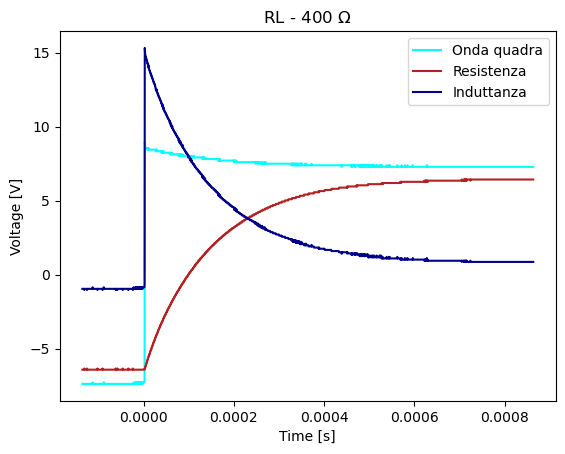

In [343]:
RL_400_s_quadra, RL_400_s_res, RL_400_s_ind  = get_data('data/RL_400_salita/')
RL_400_s_ind = RL_400_s_res[0], (RL_400_s_quadra[1] - RL_400_s_res[1])

plt.title('RL - 400 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RL_400_s_quadra[0],    RL_400_s_quadra[1],                     c='cyan')
plt.plot(RL_400_s_res[0],       RL_400_s_res[1],                        c='firebrick')
plt.plot(RL_400_s_ind[0],       RL_400_s_ind[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Induttanza'])
plt.show()

In [344]:
i = 0
v = RL_400_s_ind[1][0]
print(v)
while(v < np.max(RL_400_s_res[1])):
    v = RL_400_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 400 $\Omega$')
plt.plot(RL_400_s_quadra[0][i:],RL_400_s_quadra[1][i:],c='cyan')
plt.plot(RL_400_s_res[0][i:],RL_400_s_res[1][i:], c='firebrick')
plt.plot(RL_400_s_ind[0][i:],RL_400_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-0.9632000000000005002
347


In [346]:
c = LeastSquares(RL_100_s_ind[0][347:],RL_100_s_ind[1][347:], .1, V_RL)
m = Minuit(c, R = 400+R_g,V_o=6, T=0.025, L=25e-3, offset=0)
m.limits['L','R'] = (0,np.inf)
m.fixed['T','R'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8484 (χ²/ndof = 3.9)       │              Nfcn = 136              │
│ EDM = 3.08e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │   6.222   │   0.008   │            │            │         │         │       │
│ 1 │ R      │    472    │     5     │            │            │    0    │         │  yes  │
│ 2 │ L      │ 228.6e-3  │  0.8e-3   │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │  -0.337   │   0.020   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │      V_o        R        L        T   offset │
├────────┼──────────────────────────────────────────────┤
│    V_o │ 6.72e-05        0   5.5e-6        0 -0.15e-3 │
│      R │        0        0        0        0        0 │
│      L │   5.5e-6        0 6.52e-07        0 -15.7e-6 │
│      T │        0        0        0        0        0 │
│ offset │ -0.15e-3        0 -15.7e-6        0 0.000401 │
└────────┴──────────────────────────────────────────────┘

## RL3
<p1> R = 1k $\Omega$

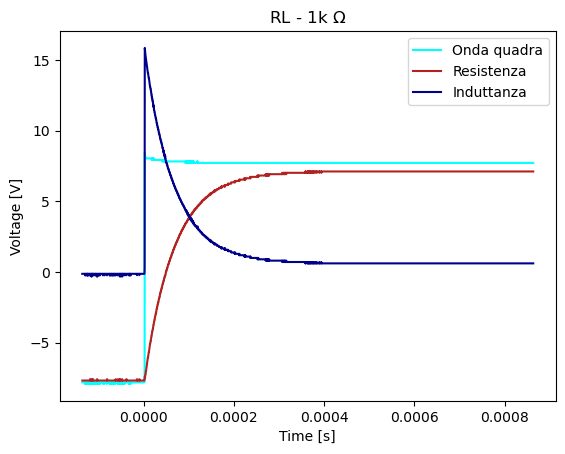

In [347]:
RL_1k_s_quadra, RL_1k_s_res, RL_1k_s_ind  = get_data('data/RL_1k_salita/')
RL_1k_s_ind = RL_1k_s_res[0], (RL_1k_s_quadra[1] - RL_1k_s_res[1])

plt.title('RL - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RL_1k_s_quadra[0],    RL_1k_s_quadra[1],                     c='cyan')
plt.plot(RL_1k_s_res[0],       RL_1k_s_res[1],                        c='firebrick')
plt.plot(RL_1k_s_ind[0],       RL_1k_s_ind[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Induttanza'])
plt.show()

In [348]:
i = 0
v = RL_1k_s_ind[1][0]
print(v)
while(v < np.max(RL_1k_s_res[1])):
    v = RL_1k_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 1k $\Omega$')
plt.plot(RL_1k_s_quadra[0][i:],RL_1k_s_quadra[1][i:],c='cyan')
plt.plot(RL_1k_s_res[0][i:],RL_1k_s_res[1][i:], c='firebrick')
plt.plot(RL_1k_s_ind[0][i:],RL_1k_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-0.13440000000000029701
347


In [374]:
c = LeastSquares(RL_1k_s_ind[0][347:],RL_1k_s_ind[1][347:], .01, V_RL)
m = Minuit(c, R = 1000+R_g+R_L,V_o=6, T=0.025, L=25e-3, offset=0)
m.limits['L','R'] = (0,np.inf)
m.fixed['T','R'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.654e+04 (χ²/ndof = 7.7)  │              Nfcn = 97               │
│ EDM = 1.18e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  7.8256   │  0.0009   │            │            │         │         │       │
│ 1 │ R      │  1.111e3  │  0.011e3  │            │            │    0    │         │  yes  │
│ 2 │ L      │ 72.476e-3 │ 0.012e-3  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │ 603.04e-3 │  0.26e-3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │      V_o        R        L        T   offset │
├────────┼──────────────────────────────────────────────┤
│    V_o │  7.4e-07        0 -6.96e-9        0  0.01e-6 │
│      R │        0        0        0        0        0 │
│      L │ -6.96e-9        0 1.41e-10        0 -1.30e-9 │
│      T │        0        0        0        0        0 │
│ offset │  0.01e-6        0 -1.30e-9        0 6.67e-08 │
└────────┴──────────────────────────────────────────────┘

In [377]:
2*np.sqrt((m.values['L'])/(48.193e-9))

2452.6515129472086

# Funcs

In [350]:
# def V_RLC_st(t,V_o,R,L,C):
#     '''tensione in regime sottosmorzato'''
#     betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
#     return V_o*np.exp(-t*R/L)*np.sin(t*betha)

In [351]:
# def V_RLC_sv(t,V_o,R,L,C):
#     '''tensione in regime sovrasmorzato'''
#     betha = np.sqrt( (R/L)**2 - (1/(L*C))**2 )
#     return V_o*np.exp(-t*R/L)*[np.exp(t*betha) - np.exp(-t*betha)]

In [352]:
# def V_RLC_crt(t,V_o,R,L,C):
#     '''tensione in regime critico'''
#     return V_o*t*np.exp(-t*R/L)

In [353]:
def V_RLC_1(t,V_o,R,L,C):
    '''tensione in regime sottosmorzato'''
    alpha = R/(2*L)
    omega = 1/np.sqrt(L*C)
    betha = np.sqrt(omega**2 - alpha**2)

    return V_o*np.exp(-t*alpha)*np.sin(t*betha)

In [354]:
def V_RLC_2(t,V_o,R,L,C):
    betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
    return V_o*np.exp(-t*R/L)*np.sin(t*betha)

# RLC

## RLC - sottosmorzato
<p1> R = 30 $\Omega$

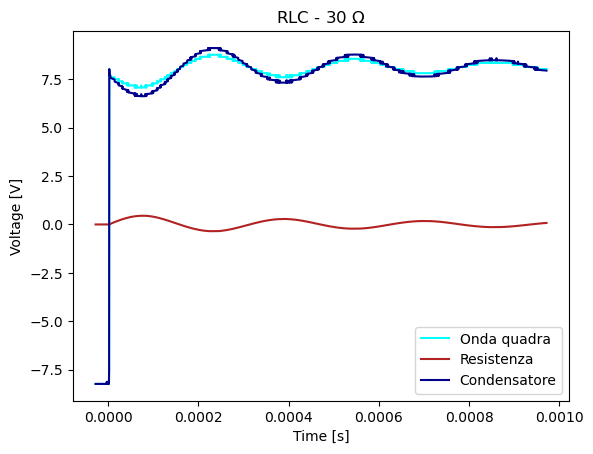

In [355]:
RLC_30_quadra, RLC_30_res, RLC_30_math = get_data('data/RLC_30/')
RLC_30_math = RLC_30_res[0], (RLC_30_quadra[1] - RLC_30_res[1])

plt.title('RLC - 30 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_30_quadra[0],    RLC_30_quadra[1],                     c='cyan')
plt.plot(RLC_30_res[0],       RLC_30_res[1],                        c='firebrick')
plt.plot(RLC_30_math[0],       RLC_30_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

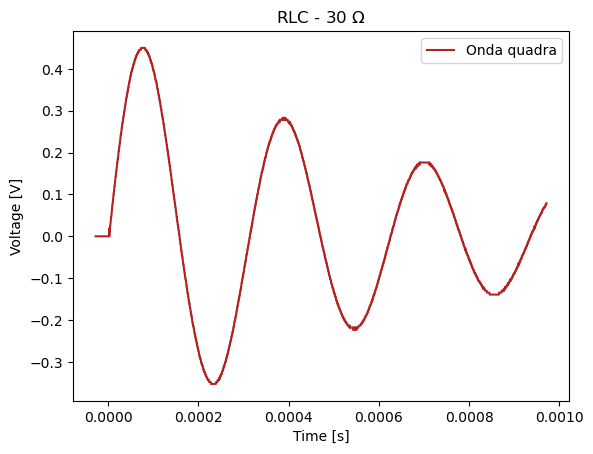

In [356]:
plt.title('RLC - 30 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_30_res[0],       RLC_30_res[1],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

76


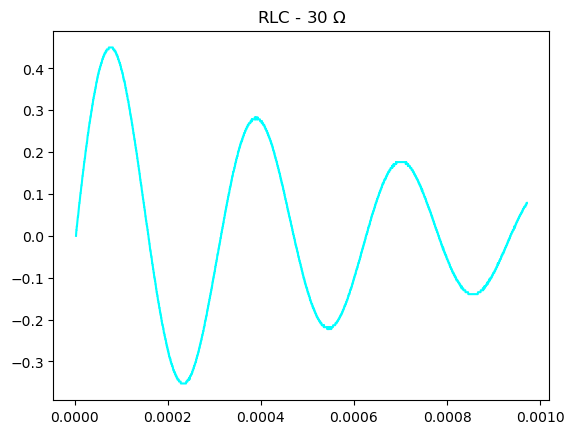

In [357]:
i = 0
v = RLC_30_res[1][0]

while(v < 0.001):
    v = RLC_30_res[1][i]
    i+=1
print(i)
plt.title('RLC - 30 $\Omega$')
plt.plot(RLC_30_res[0][i:],RLC_30_res[1][i:],c='cyan')

In [371]:
c = LeastSquares(RLC_30_res[0][i:],RLC_30_res[1][i:], .01, V_RLC_1)
m = Minuit(c, R = 30+R_g,V_o=8, L=69.1e-3	, C=48.1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.fixed['C','L'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.15e+05 (χ²/ndof = 206.3) │              Nfcn = 86               │
│ EDM = 6.71e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │  516e-3   │   1e-3    │            │            │         │         │       │
│ 1 │ R    │   493.4   │    1.2    │            │            │    0    │         │       │
│ 2 │ L    │  69.1e-3  │  0.7e-3   │            │            │    0    │         │  yes  │
│ 3 │ C    │  48.1e-9  │  0.5e-9   │            │            │    0    │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────┐
│     │      V_o        R        L        C │
├─────┼─────────────────────────────────────┤
│ V_o │ 9.88e-07 753.4e-6     0e-6     0e-6 │
│   R │ 753.4e-6     1.38      0.0      0.0 │
│   L │     0e-6      0.0        0        0 │
│   C │     0e-6      0.0        0        0 │
└─────┴─────────────────────────────────────┘

# RLC - sottosmorzato
<p1> R = 200 $\Omega$

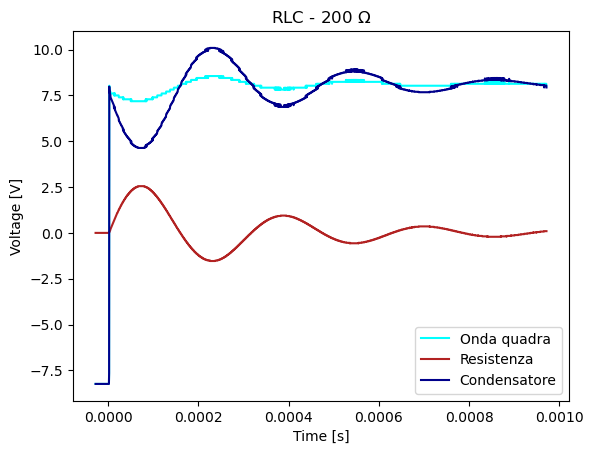

In [359]:
RLC_200_quadra, RLC_200_res, RLC_200_math = get_data('data/RLC_200/')
RLC_200_math = RLC_200_res[0], (RLC_200_quadra[1] - RLC_200_res[1])

plt.title('RLC - 200 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_200_quadra[0],    RLC_200_quadra[1],                     c='cyan')
plt.plot(RLC_200_res[0],       RLC_200_res[1],                        c='firebrick')
plt.plot(RLC_200_math[0],       RLC_200_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

76


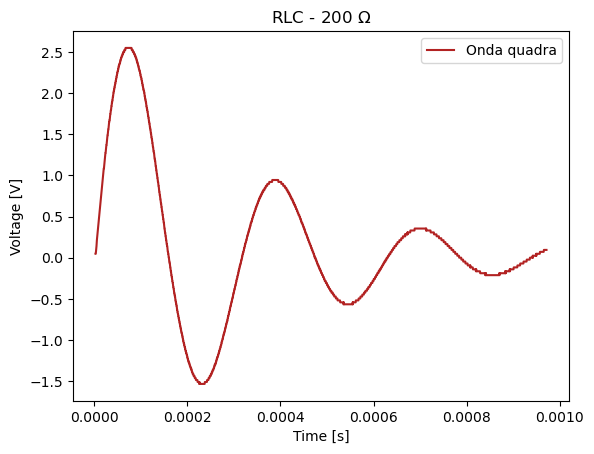

In [360]:
i = 0
v = RLC_200_res[1][0]

while(v < 0.001):
    v = RLC_200_res[1][i]
    i+=1
print(i)

plt.title('RLC - 200 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_200_res[0][i:],       RLC_200_res[1][i:],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

In [361]:
c = LeastSquares(RLC_200_res[0][i:],RLC_200_res[1][i:], .001, V_RLC_1)
m = Minuit(c, R = 200,V_o=8, L=30e-3, C=50*1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.29e+06 (χ²/ndof = 1360.0)│              Nfcn = 230              │
│ EDM = 6.72e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │  3.19920  │  0.00011  │            │            │         │         │       │
│ 1 │ R    │  124.491  │   0.020   │            │            │    0    │         │       │
│ 2 │ L    │19.8474e-3 │ 0.0030e-3 │            │            │    0    │         │       │
│ 3 │ C    │125.104e-9 │ 0.019e-9  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────┐
│     │              V_o                R                L                C │
├─────┼─────────────────────────────────────────────────────────────────────┤
│ V_o │         1.14e-08         0.444e-6           -5e-12      12.9577e-18 │
│   R │         0.444e-6         0.000389        56.643e-9 -357.5136407e-15 │
│   L │           -5e-12        56.643e-9         9.09e-12     -57.1512e-18 │
│   C │      12.9577e-18 -357.5136407e-15     -57.1512e-18         3.61e-22 │
└─────┴─────────────────────────────────────────────────────────────────────┘

# RLC - sottosmorzato
<p1> R = 1k $\Omega$

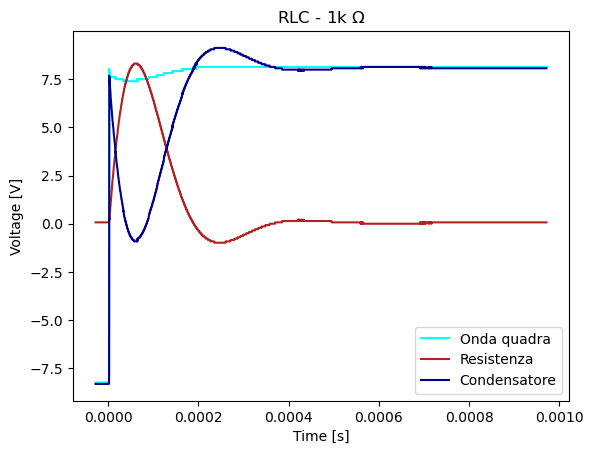

In [362]:
RLC_1k_quadra, RLC_1k_res, RLC_1k_math = get_data('data/RLC_1k/')
RLC_1k_math = RLC_1k_res[0], (RLC_1k_quadra[1] - RLC_1k_res[1])

plt.title('RLC - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_1k_quadra[0],    RLC_1k_quadra[1],                     c='cyan')
plt.plot(RLC_1k_res[0],       RLC_1k_res[1],                        c='firebrick')
plt.plot(RLC_1k_math[0],       RLC_1k_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

0


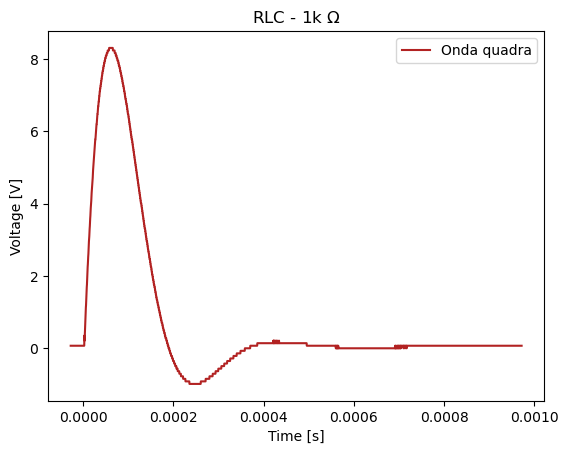

In [363]:
i = 0
v = RLC_1k_res[1][0]

while(v < 0.001):
    v = RLC_1k_res[1][i]
    i+=1
print(i)

plt.title('RLC - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_1k_res[0][i:],       RLC_1k_res[1][i:],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

In [364]:
c = LeastSquares(RLC_1k_res[0][i:],RLC_1k_res[1][i:], .001, V_RLC_1)
m = Minuit(c, R = 1000,V_o=8, L=30e-3, C=50*1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.575e+09 (χ²/ndof = 631454.9)│              Nfcn = 148              │
│ EDM = 2.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │ 12.88995  │  0.00017  │            │            │         │         │       │
│ 1 │ R    │   914.8   │    0.4    │            │            │    0    │         │       │
│ 2 │ L    │ 61.373e-3 │ 0.030e-3  │            │            │    0    │         │       │
│ 3 │ C    │ 49.646e-9 │ 0.024e-9  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────┐
│     │                V_o                  R                  L                  C │
├─────┼─────────────────────────────────────────────────────────────────────────────┤
│ V_o │           2.99e-08          -0.265e-6            -0.1e-9       110.0162e-18 │
│   R │          -0.265e-6              0.197         13.2256e-6 -10.6970744590e-12 │
│   L │            -0.1e-9         13.2256e-6           8.88e-10      -718.2122e-18 │
│   C │       110.0162e-18 -10.6970744590e-12      -718.2122e-18           5.81e-22 │
└─────┴─────────────────────────────────────────────────────────────────────────────┘